In [1]:
import torch
from torch import nn
import numpy as np
import scipy
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
from lib import forward_diffusion, reverse_diffusion, make_schedule, DDPM
import os

## Two moons distribution

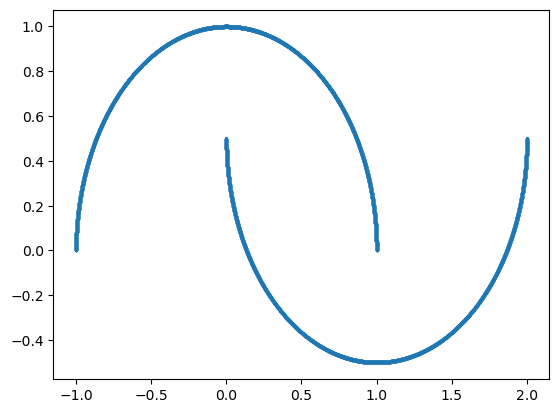

In [2]:
X_train, y_train = make_moons(n_samples=10000) 
plt.scatter(X_train[:,0],X_train[:,1],s=2)

Text(0.5, 0, 'rvar (reverse variance)')

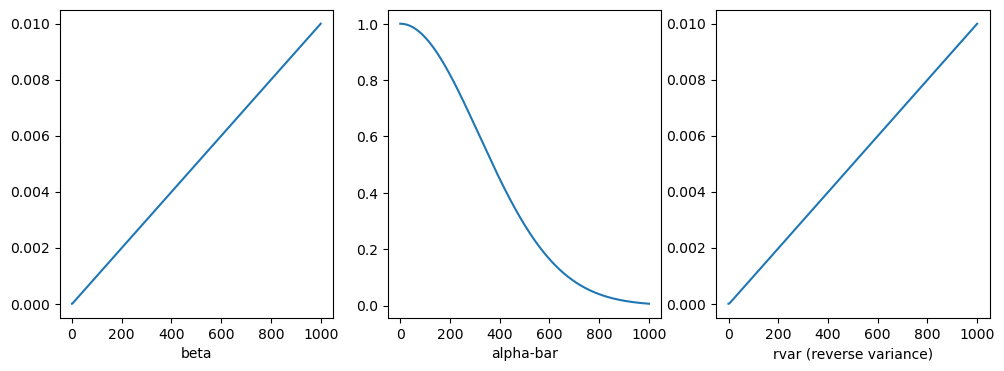

In [3]:
T = 1000
schedule = make_schedule(scheme='linear',rvar='fvar', T=T, start_beta=1e-6, end_beta=1e-2)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha-bar')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar (reverse variance)')
#print(schedule['alpha'])

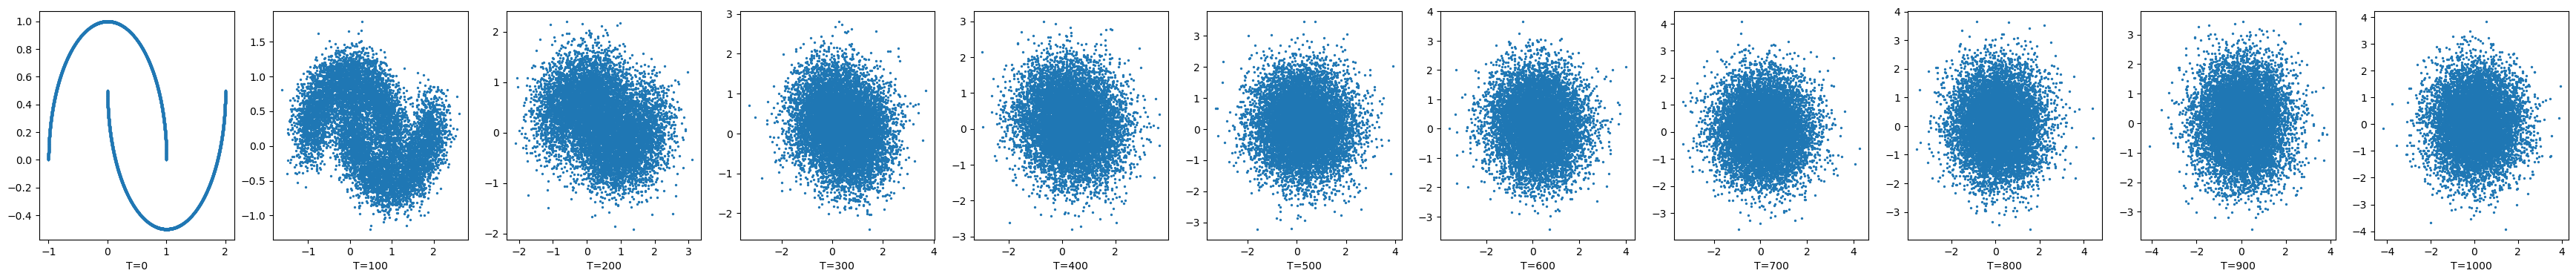

In [4]:
numsamples = 11
f, ax = plt.subplots(ncols=numsamples,figsize=(4*numsamples,4))
datavis = np.copy(X_train)
for idx,t in enumerate(np.linspace(start=0, stop=T, endpoint=True, num=numsamples)):
    t = int(t)
    _datavis = forward_diffusion(datavis, 0, t, schedule)
    ax[idx].scatter(_datavis[:,0],_datavis[:,1],s=2)
    ax[idx].set_xlabel('T='+str(t))


In [5]:
class simpleMLP(torch.nn.Module):
    def __init__(self, inpfeat):
        super().__init__()    
        self.model1 = nn.Sequential(nn.Linear(inpfeat,64),nn.ReLU(),nn.Linear(64,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,64))
        self.model2 = nn.Sequential(nn.Linear(1,64),nn.ReLU(),nn.Linear(64,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,64))
        self.model3 = nn.Sequential(nn.Linear(128,128),nn.ReLU(),nn.Linear(128,64),nn.ReLU(),nn.Linear(64,16),nn.ReLU(),nn.Linear(16,inpfeat))
 
    def forward(self, x, t):
        x = self.model1(x)
        t = self.model2(((t-(T/2))/T).unsqueeze(-1))
        x_t = torch.cat((x,t),-1)
        return self.model3(x_t)


def train(ddpm_model, X_train, num_epochs, batch_size, savefreq, prefix):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    X_train_torch = torch.Tensor(np.asarray(X_train,dtype=np.float32))
    dataloader = torch.utils.data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=True)

    for epoch in range(1,num_epochs+1):
        LOSS = 0
        ITER = 0
        for data_x in dataloader:
            optimizer.zero_grad()
            loss = ddpm_model.run_step(data_x)
            loss.backward()
            optimizer.step()
            LOSS += loss.item()
            ITER += 1
        print(f"epoch = {epoch}, loss = {LOSS/ITER}")  
        if epoch % savefreq == 0:
            
            D = {'model_state_dict': ddpm_model.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch }
            if not os.path.exists('./ckpts'):
                os.mkdir('ckpts')
            torch.save(D,'./ckpts/'+prefix+'-'+str(epoch)+'.ckpt')    

def infer(ddpm_model, schedule, inpfeat, prefix):
        z = np.random.normal(loc=0, scale=1.0, size=(10000,inpfeat))
        z = np.asarray(z,dtype=np.float32)
        f, ax = plt.subplots(ncols=3, figsize=(18,6))
        ax[0].scatter(X_train[:,0],X_train[:,1])
        ax[0].set_xlabel('train data i.e '+ prefix + ' distribution')
        ax[1].scatter(z[:,0],z[:,1])
        ax[1].set_xlabel('initialization samples i.e X_T ~ std normal')
        x = z
        for t in range(0,T):
                x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=True, schedule=schedule, onlymean=False)
        pred_samples = x
        assert pred_samples.shape == z.shape
        ax[2].scatter(pred_samples[:,0],pred_samples[:,1])
        ax[2].set_xlabel('predicted '+prefix+' distribution')


### Training with weighted loss i.e the $L_{original}$ from the DDPM paper

Training with weighted loss i.e the original DDPM loss
epoch = 1, loss = 0.008632032265532998


epoch = 2, loss = 0.008200346745692099
epoch = 3, loss = 0.007200415234399747
epoch = 4, loss = 0.007936759692722862
epoch = 5, loss = 0.007273480281398832
epoch = 6, loss = 0.00602210644791728
epoch = 7, loss = 0.005363026352398852
epoch = 8, loss = 0.006504472236066491
epoch = 9, loss = 0.00591518988986087
epoch = 10, loss = 0.005996981931885681
epoch = 11, loss = 0.0056587871564905854
epoch = 12, loss = 0.006283331022868994
epoch = 13, loss = 0.005946135242717175
epoch = 14, loss = 0.006148531876763777
epoch = 15, loss = 0.005163574672327672
epoch = 16, loss = 0.0062782196210155
epoch = 17, loss = 0.005983461948594998
epoch = 18, loss = 0.006985825489428413
epoch = 19, loss = 0.00552011906210616
epoch = 20, loss = 0.006220001717027324
epoch = 21, loss = 0.005918193721990514
epoch = 22, loss = 0.0061526792477580566
epoch = 23, loss = 0.006315093164043383
epoch = 24, loss = 0.006347718352416554
epoch = 25, loss = 0.006093591379437925
epoch = 26, loss = 0.006208111249099049
epoch = 27,

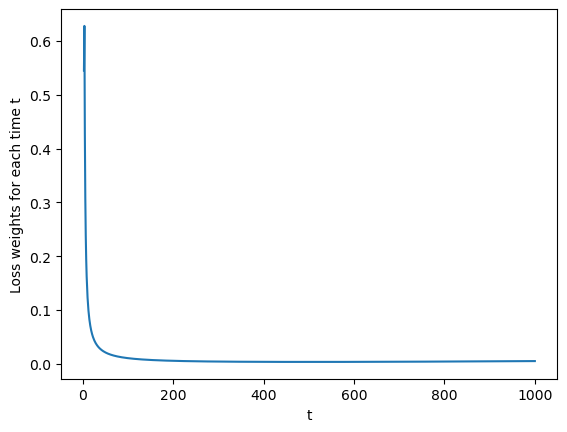

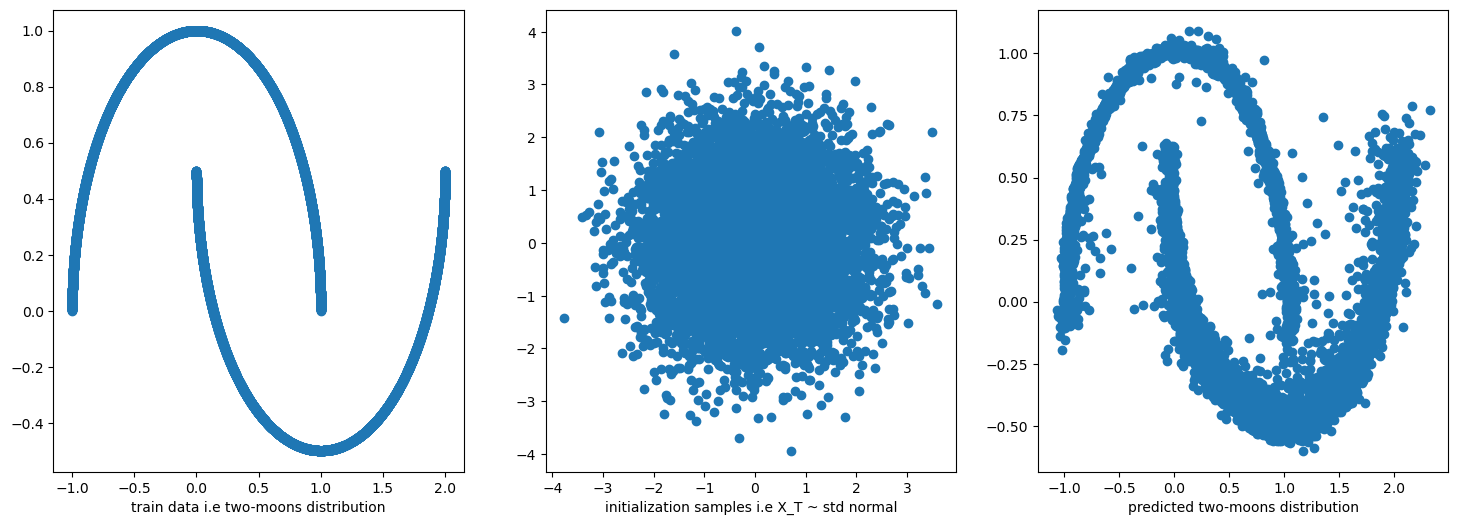

In [6]:
model = simpleMLP(inpfeat=2)
print('Training with weighted loss i.e the original DDPM loss')
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=True,cuda=True)
plt.plot(np.arange(2,T+1,step=1),ddpm_model.loss_weights[2:])
plt.xlabel('t')
plt.ylabel('Loss weights for each time t')
train(ddpm_model, X_train, num_epochs=1000, batch_size=128, savefreq=1000, prefix='two-moons-wl')
infer(ddpm_model, schedule, inpfeat=2, prefix='two-moons')

### Training with unweighted loss i.e $L_{simple}$ from the DDPM paper

Training with un-weighted loss i.e the Simple loss in DDPM
epoch = 1, loss = 0.6144682263271718
epoch = 2, loss = 0.3249338022138499


epoch = 3, loss = 0.3076056941777845
epoch = 4, loss = 0.296467060529733
epoch = 5, loss = 0.2914090594158897
epoch = 6, loss = 0.30026195830182184
epoch = 7, loss = 0.2774818784828427
epoch = 8, loss = 0.27967922144298313
epoch = 9, loss = 0.29201296801808513
epoch = 10, loss = 0.2952264641659169
epoch = 11, loss = 0.29050615165807026
epoch = 12, loss = 0.29839964097813715
epoch = 13, loss = 0.28578415795972073
epoch = 14, loss = 0.2816566617428502
epoch = 15, loss = 0.2820077557352525
epoch = 16, loss = 0.28068977556651153
epoch = 17, loss = 0.2798235571082634
epoch = 18, loss = 0.2761802118790301
epoch = 19, loss = 0.2725935542508017
epoch = 20, loss = 0.27781388559673403
epoch = 21, loss = 0.28364945325670365
epoch = 22, loss = 0.2747133138436305
epoch = 23, loss = 0.2733929332675813
epoch = 24, loss = 0.28019892905331867
epoch = 25, loss = 0.29227480763875985
epoch = 26, loss = 0.2735288925940477
epoch = 27, loss = 0.27817982623848736
epoch = 28, loss = 0.2763548410391506
epoch = 

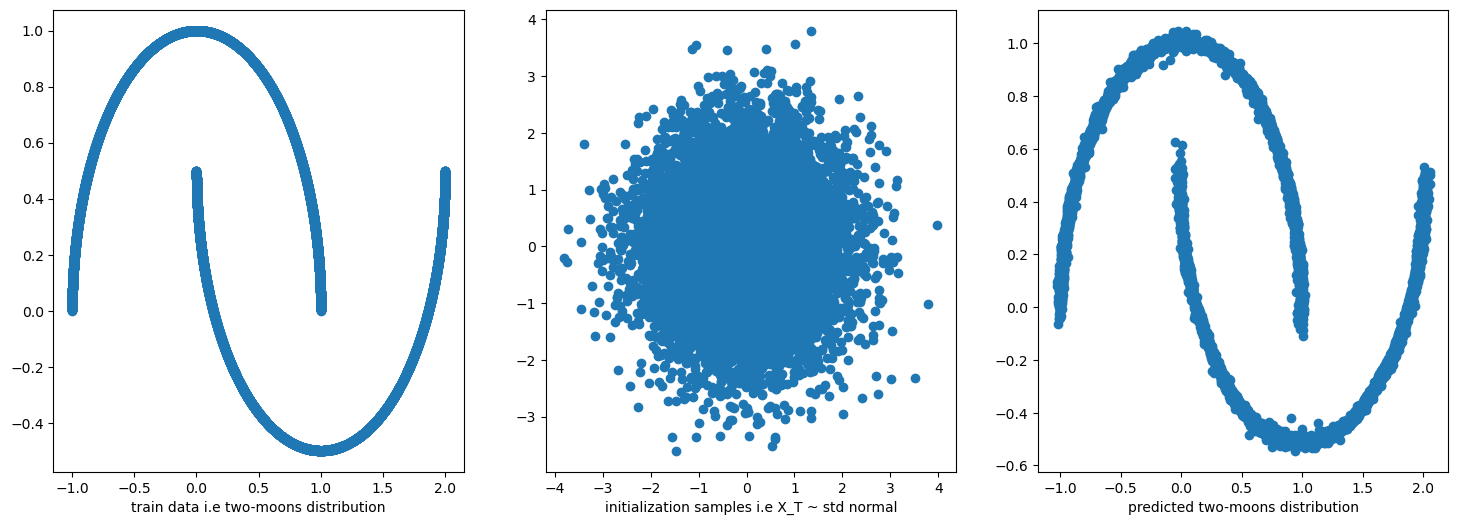

In [7]:
model = simpleMLP(inpfeat=2)
print('Training with un-weighted loss i.e the Simple loss in DDPM')
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=False,cuda=True)
train(ddpm_model, X_train, num_epochs=1000, batch_size=128, savefreq=1000, prefix='two-moons-uwl')
infer(ddpm_model, schedule, inpfeat=2, prefix='two-moons')

## 2D projected Swiss roll distribution

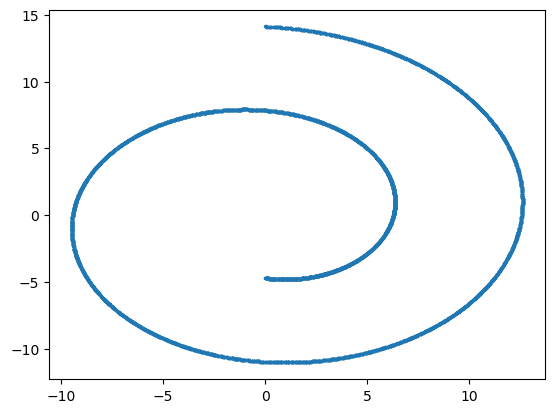

In [8]:
X_train, y_train = make_swiss_roll(n_samples=10000) 
X_viztrain = X_train[:,[0,2]]
plt.scatter(X_viztrain[:,0],X_viztrain[:,1],s=2)
X_train = X_train[:,[0,2,1]]

Text(0.5, 0, 'rvar')

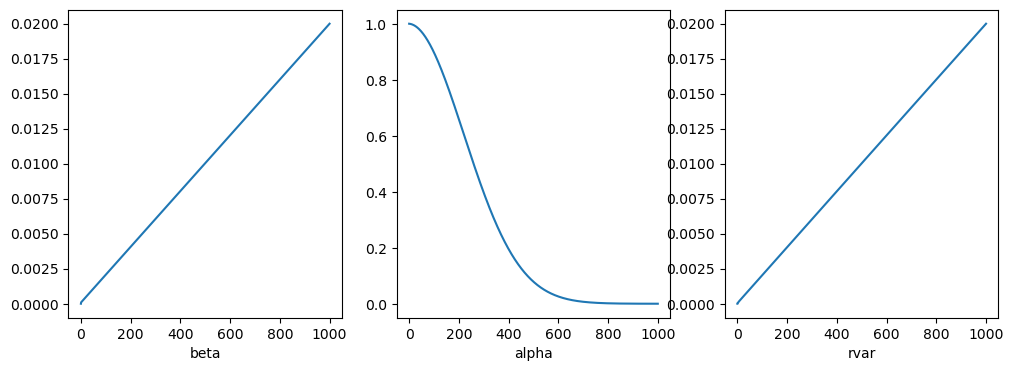

In [9]:
T = 1000
schedule = make_schedule(scheme='linear',rvar='fvar', T=T, start_beta=1e-4, end_beta=2e-2)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar')
#print(schedule['alpha'])

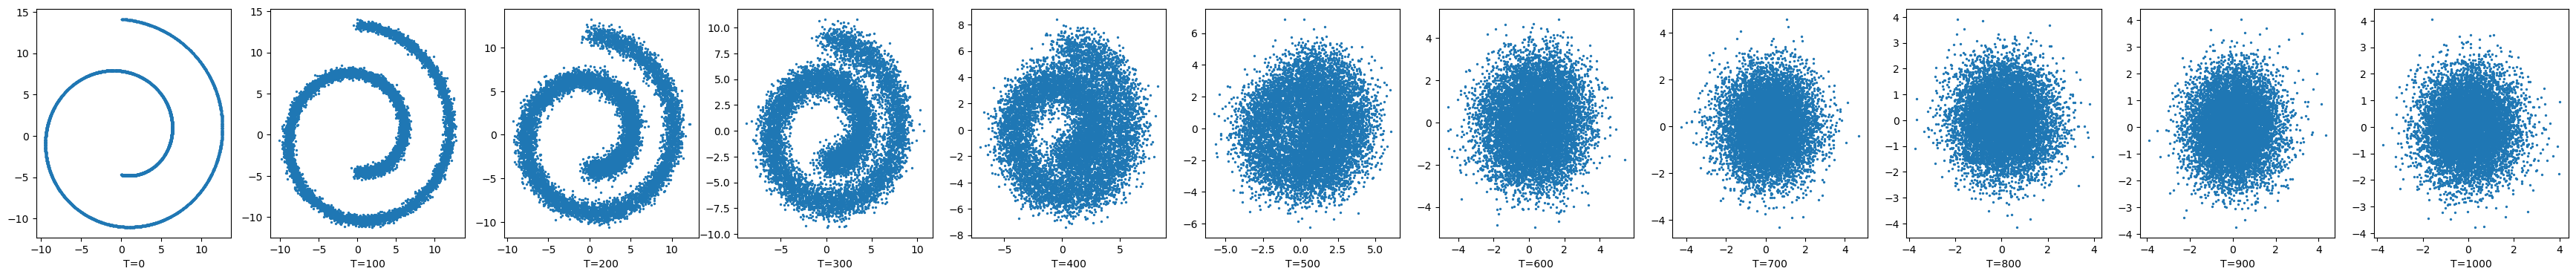

In [10]:
numsamples = 11
f, ax = plt.subplots(ncols=numsamples,figsize=(4*numsamples,4))
datavis = np.copy(X_viztrain)
for idx,t in enumerate(np.linspace(start=0, stop=T, endpoint=True, num=numsamples)):
    t = int(t)
    _datavis = forward_diffusion(datavis, 0, t, schedule)
    ax[idx].scatter(_datavis[:,0],_datavis[:,1],s=2)
    ax[idx].set_xlabel('T='+str(t))

### Training with weighted loss i.e the $L_{original}$ from the DDPM paper

Training with weighted loss i.e the original DDPM loss
epoch = 1, loss = 0.009448666903602927
epoch = 2, loss = 0.00838188861225602
epoch = 3, loss = 0.008041303115602158
epoch = 4, loss = 0.007965826450057233


epoch = 5, loss = 0.006682433485631136
epoch = 6, loss = 0.0070655148924340175
epoch = 7, loss = 0.006996231654635336
epoch = 8, loss = 0.0073054337143143525
epoch = 9, loss = 0.0068009116103330365
epoch = 10, loss = 0.007205277631247911
epoch = 11, loss = 0.007273925600950665
epoch = 12, loss = 0.007798293293041142
epoch = 13, loss = 0.007398226787630893
epoch = 14, loss = 0.007003982300881909
epoch = 15, loss = 0.006729899404594038
epoch = 16, loss = 0.006797539824737778
epoch = 17, loss = 0.006765517974979704
epoch = 18, loss = 0.006644911253589052
epoch = 19, loss = 0.0071782234266306024
epoch = 20, loss = 0.00719878496012733
epoch = 21, loss = 0.006220254528371594
epoch = 22, loss = 0.006936128313146248
epoch = 23, loss = 0.00719565697768821
epoch = 24, loss = 0.0068528360504468405
epoch = 25, loss = 0.007576337623516027
epoch = 26, loss = 0.007681681420889836
epoch = 27, loss = 0.007247335701897929
epoch = 28, loss = 0.0069139438498576605
epoch = 29, loss = 0.0068678463885819985


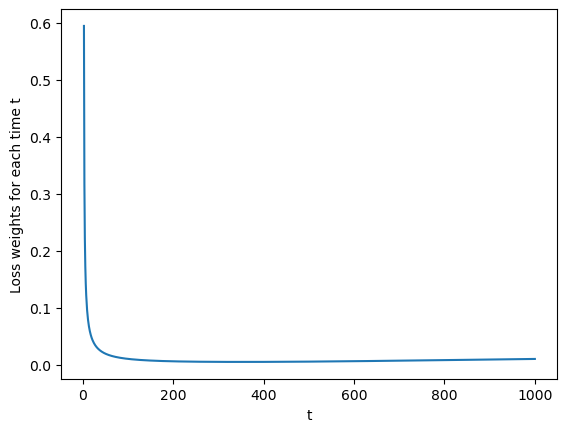

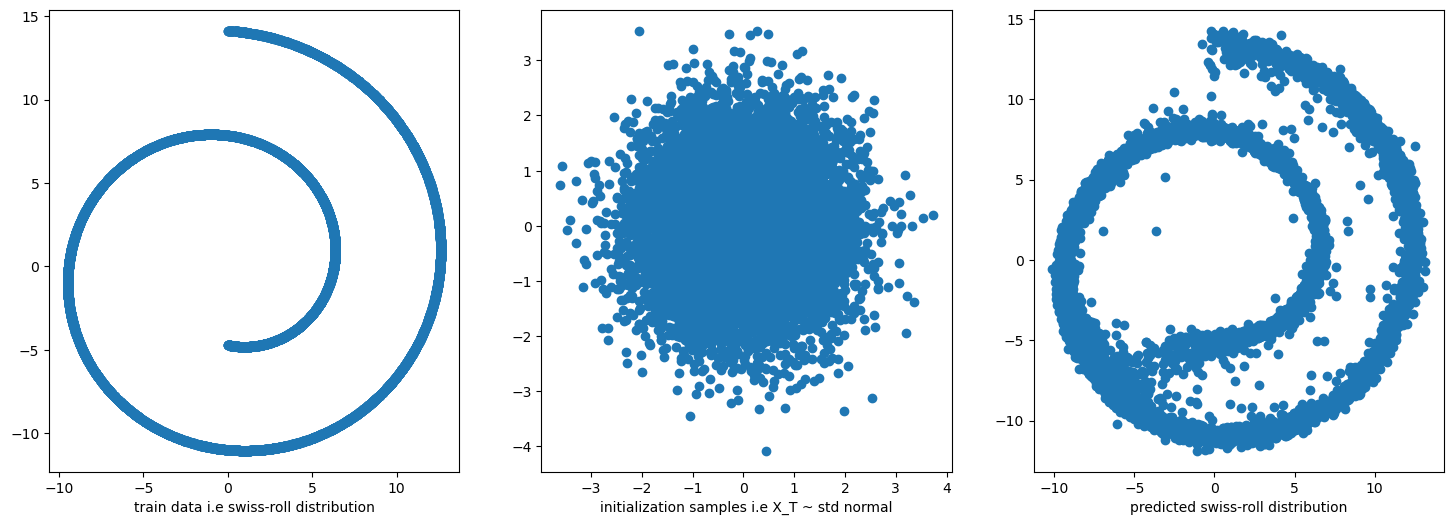

In [11]:
model = simpleMLP(inpfeat=3)
print('Training with weighted loss i.e the original DDPM loss')
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=True,cuda=True)
plt.plot(np.arange(2,T+1,step=1),ddpm_model.loss_weights[2:])
plt.xlabel('t')
plt.ylabel('Loss weights for each time t')
train(ddpm_model, X_train, num_epochs=1000, batch_size=128, savefreq=1000, prefix='swiss-roll-wl')
infer(ddpm_model, schedule, inpfeat=3, prefix='swiss-roll')

### Training with weighted loss i.e the $L_{simple}$ from the DDPM paper

Training with un-weighted loss i.e the Simple loss in DDPM
epoch = 1, loss = 0.8401429321192488
epoch = 2, loss = 0.6430804593653618
epoch = 3, loss = 0.6209715944302233
epoch = 4, loss = 0.6050150156775608
epoch = 5, loss = 0.5869436343259449
epoch = 6, loss = 0.5879574866988991
epoch = 7, loss = 0.5756659315356726
epoch = 8, loss = 0.5765367535096181
epoch = 9, loss = 0.5839814528634276
epoch = 10, loss = 0.589778033238423
epoch = 11, loss = 0.5783575052701975
epoch = 12, loss = 0.5657548802562907
epoch = 13, loss = 0.5696512019332451
epoch = 14, loss = 0.5506614737118347
epoch = 15, loss = 0.5662894758242595
epoch = 16, loss = 0.5628520597385455
epoch = 17, loss = 0.5733448565006256
epoch = 18, loss = 0.5455817376511006
epoch = 19, loss = 0.5609852445276478
epoch = 20, loss = 0.559056584593616
epoch = 21, loss = 0.5485686957836151
epoch = 22, loss = 0.5509638194041916
epoch = 23, loss = 0.5522156082376649
epoch = 24, loss = 0.5532843104646176
epoch = 25, loss = 0.5513618109346945
ep

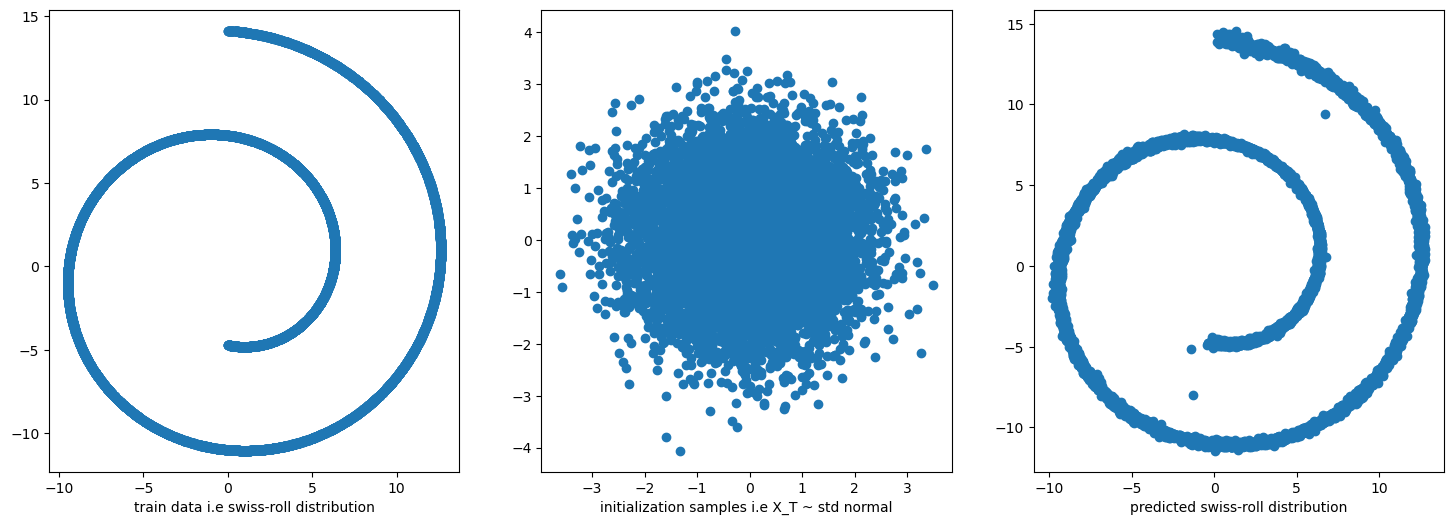

In [12]:
model = simpleMLP(inpfeat=3)
print('Training with un-weighted loss i.e the Simple loss in DDPM')
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=False,cuda=True)
train(ddpm_model, X_train, num_epochs=1000, batch_size=128, savefreq=1000, prefix='swiss-roll-uwl')
infer(ddpm_model, schedule, inpfeat=3, prefix='swiss-roll')